# Day-ahead forecast

Download the file `Final.zip` from [this url](https://ieee-dataport.org/competitions/day-ahead-electricity-demand-forecasting-post-covid-paradigm#files) and extract the file `Actuals.xlsx` into `../outputs/`.

In [14]:
import jax
import numpy as np 
import pandas as pd
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
from datetime import datetime
from functools import partial
from bayes_opt import BayesianOptimization
from rebayes_mini.methods.gauss_filter import GaussianFilter, ExtendedKalmanFilter
from rebayes_mini.methods.adaptive import ExpfamRLSR, ExpfamRLPR, ExpfamEBA

In [15]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 15
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
plt.rc("text", usetex=True)

sns.set_palette("colorblind")

## Download data

In [16]:
data = pd.read_excel("../outputs/Actuals.xlsx")
data = data.set_index("Time")

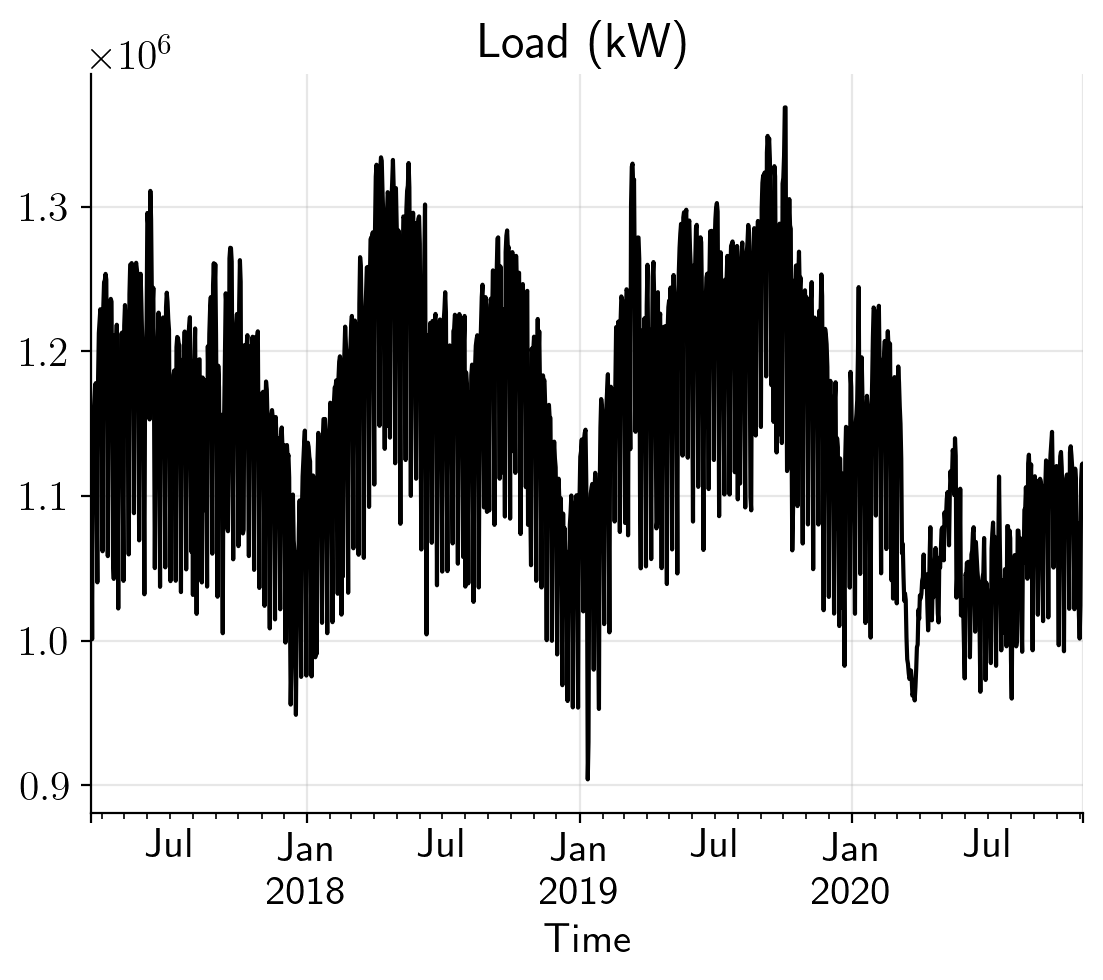

In [17]:
data.resample("D").mean()["Load (kW)"].plot(c="black")
plt.title("Load (kW)")
plt.grid(alpha=0.3)

## Preprocess data

In [18]:
target = "Load (kW)"

k_ahead = 1

y = data[target]#.diff()
series_mean = y.ewm(halflife=20).mean().shift(1)
series_std = y.ewm(halflife=20).std().shift(1)
y = (y - series_mean) / series_std

y = y.dropna()
index = y.index

y = jnp.array(y.shift(-k_ahead).values)[:-k_ahead]

X = data.loc[index].drop(target, axis=1)
X = X / X.ewm(span=20).std()

X = jnp.array(X)[:-k_ahead]

norm_periods = 100

vinit = np.nanvar(y[:norm_periods])
y = y[norm_periods:]
X = X[norm_periods:]
index = index[norm_periods:]

_, dim_features = X.shape

In [19]:
mae_baseline = np.abs(y - pd.Series(y).expanding().mean()).mean()
baseline_rolling = y - pd.Series(y).rolling(100).mean()

In [20]:
hist_collection = {"baseline": baseline_rolling}
mae_collection = {"baseline": mae_baseline}

## Base neural net

In [21]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(4)(x)
        x = nn.relu(x)
        x = nn.Dense(4)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

In [22]:
key = jax.random.PRNGKey(314)
model = MLP()
params_init = model.init(key, X[:1])

## C-ACI

In [23]:
method = "C-ACI"

In [24]:
def callback(bel, bel_prior, y, X, filter):
    # yhat = model.apply(bel_prior, X)
    yhat = filter.vobs_fn(bel_prior.mean, X)
    out = {
        "yhat": yhat,
        "err": y - yhat,
    }
    return out

In [25]:
def bo_select(logq):
    q = np.exp(logq)
    base_filter = ExtendedKalmanFilter(
        lambda x: x, model.apply, dynamics_covariance=q * jnp.eye(53),
        observation_covariance=1.0
    )
    bel_init = base_filter.init_bel(params_init)
    partc = partial(callback, filter=base_filter)
    _, hist = base_filter.scan(bel_init, y[:300, None], X[:300], partc)

    mae = np.abs(hist["err"]).mean()
    
    
    return -np.median(np.abs(hist["err"]))

In [26]:
boundaries = {
    "logq": [-20, 0]
}
bo = BayesianOptimization(bo_select, boundaries, random_state=3141, allow_duplicate_points=True)
bo.maximize(init_points=5, n_iter=10)

|   iter    |  target   |   logq    |
-------------------------------------
| 1         | -0.8875   | -18.19    |
| 2         | -0.8436   | -7.53     |
| 3         | -0.887    | -12.05    |
| 4         | -0.6765   | -3.323    |
| 5         | -0.6557   | -3.177    |
| 6         | -0.4861   | -2.067    |
| 7         | -0.2679   | -0.000959 |
| 8         | -0.2719   | -0.1085   |
| 9         | -0.268    | -0.003837 |
| 10        | -0.2678   | -0.000611 |
| 11        | -0.2678   | -0.000395 |
| 12        | -0.2678   | -0.000215 |
| 13        | -0.268    | -0.003023 |
| 14        | -0.2679   | -0.001178 |
| 15        | -0.2678   | -8.296e-0 |


In [27]:
base_filter = ExtendedKalmanFilter(
    lambda x: x, model.apply, dynamics_covariance=jnp.exp(0)* jnp.eye(53),
    observation_covariance=1.0
)

In [28]:
# bel_init = base_filter.init_bel(jnp.zeros(dim_features))
bel_init = base_filter.init_bel(params_init)
partc = partial(callback, filter=base_filter)
_, hist = base_filter.scan(bel_init, y, X, partc)

In [29]:
mae = np.abs(hist["err"]).mean()

hist_collection[method] = hist["err"]

format(np.median(np.abs(hist["err"])), ",.6f")

'0.260881'

## RL-OUPR

In [30]:
def callback(bel, bel_prev, y, X, ixs, filter):
    log_posterior = bel_prev.log_joint - jax.nn.logsumexp(bel_prev.log_joint, keepdims=True)
    posterior = jnp.exp(log_posterior)
    
    log_posterior = bel_prev.log_joint - jax.nn.logsumexp(bel_prev.log_joint, keepdims=True)
    posterior = jnp.exp(log_posterior)
    eta = jax.vmap(filter.filter.link_fn, in_axes=(0, None))(bel_prev.mean, X).astype(float)
    mean = jax.vmap(filter.filter.mean)(eta)
    mean = jnp.einsum("k,km->m", posterior, mean)
    
    out = {
        # "log_joint": bel.log_joint,
        "runlenght": bel.runlength,
        # "ixs": ixs,
        "posterior": posterior,
        "yhat": mean,
        "err": mean - y,
    }
    return out


In [31]:
def bo_select(logq, logp, shock):
    q = np.exp(logq)
    p = np.exp(logp)
    
    base_filter = GaussianFilter(model.apply, dynamics_covariance=q, variance=1.0)
    filter = ExpfamRLSR(p, K=1, shock=shock, deflate_mean=False, filter=base_filter)
    
    bel_init = filter.init_bel(params_init, cov=1.0, log_joint_init=0.0)

    partc = partial(callback, filter=filter)
    _, hist = filter.scan(y[:300, None], X[:300], bel_init, partc)
    
    mae = np.abs(hist["err"]).mean()
    
    
    return -mae

In [32]:
boundaries = {
    "logq": [-20, 0],
    "logp": [-20, 0],
    "shock": [0, 2.0],
}
bo = BayesianOptimization(bo_select, boundaries, random_state=3141, allow_duplicate_points=True)
bo.maximize(init_points=5, n_iter=10)

|   iter    |  target   |   logp    |   logq    |   shock   |
-------------------------------------------------------------
| 1         | -0.8579   | -18.19    | -7.53     | 0.7947    |
| 2         | -0.6505   | -3.323    | -3.177    | 0.4974    |
| 3         | -0.7748   | -15.76    | -4.145    | 1.812     |
| 4         | -0.8849   | -11.34    | -18.51    | 1.808     |
| 5         | -0.5414   | -2.228    | -5.637    | 1.024     |
| 6         | -0.884    | -0.135    | -9.338    | 0.3538    |
| 7         | -0.3798   | -1.508    | -4.424    | 1.926     |
| 8         | -0.884    | -0.1058   | -3.5      | 1.724     |
| 9         | -0.4309   | -1.972    | -4.834    | 1.799     |
| 10        | -0.437    | -2.169    | -3.799    | 1.913     |
| 11        | -0.3484   | -1.072    | -6.094    | 1.956     |
| 12        | -0.884    | -0.1003   | -5.903    | 0.7835    |
| 13        | -0.4272   | -2.045    | -6.657    | 1.985     |
| 14        | -0.691    | -4.254    | -7.19     | 1.755     |
| 15    

In [33]:
pmax = bo.max["params"]
q = np.exp(pmax["logq"])
p = np.exp(pmax["logp"])
shock = np.exp(pmax["shock"])

In [34]:
method = "RL-OUPR"

base_filter = GaussianFilter(model.apply, dynamics_covariance=q, variance=1.0)
filter = ExpfamRLSR(p, K=1, shock=shock, deflate_mean=False, filter=base_filter)

In [35]:
bel_init = filter.init_bel(params_init, cov=1.0, log_joint_init=0.0)

partc = partial(callback, filter=filter)
_, hist = filter.scan(y[:, None], X, bel_init, partc)
mae = np.abs(hist["err"]).mean()

hist_collection[method] = hist["err"]

format(np.median(np.abs(hist["err"])), ",.6f")

'0.199064'

## RL-PR

In [36]:
def callback(bel, bel_prev, y, X, ixs, filter):
    log_posterior = bel_prev.log_joint - jax.nn.logsumexp(bel_prev.log_joint, keepdims=True)
    posterior = jnp.exp(log_posterior)
    
    log_posterior = bel_prev.log_joint - jax.nn.logsumexp(bel_prev.log_joint, keepdims=True)
    posterior = jnp.exp(log_posterior)
    eta = jax.vmap(filter.filter.link_fn, in_axes=(0, None))(bel_prev.mean, X).astype(float)
    mean = jax.vmap(filter.filter.mean)(eta)
    mean = jnp.einsum("k,km->m", posterior, mean)
    
    out = {
        "runlenght": bel.runlength,
        # "ixs": ixs,
        "posterior": posterior,
        "yhat": mean,
        "err": mean - y,
    }
    return out


In [37]:
def bo_select(logp):
    p = np.exp(logp)

    base_filter = GaussianFilter(model.apply, dynamics_covariance=0.0, variance=1.0)
    filter = ExpfamRLPR(p, K=3, filter=base_filter)
    
    bel_init = filter.init_bel(params_init, cov=1.0, log_joint_init=0.0)

    partc = partial(callback, filter=filter)
    _, hist = filter.scan(y[:300, None], X[:300], bel_init, partc)

    mae = np.abs(hist["err"]).mean()
    
    
    return -mae

In [38]:
boundaries = {
    "logp": [-20, 0.0],
}
bo = BayesianOptimization(bo_select, boundaries, random_state=3141, allow_duplicate_points=True)
bo.maximize(init_points=5, n_iter=10)

|   iter    |  target   |   logp    |
-------------------------------------
| 1         | -0.8868   | -18.19    |
| 2         | -0.8846   | -7.53     |
| 3         | -0.8867   | -12.05    |
| 4         | -0.7105   | -3.323    |
| 5         | -0.7046   | -3.177    |
| 6         | -0.8839   | -0.000211 |
| 7         | -0.6212   | -1.993    |
| 8         | -0.8868   | -15.12    |
| 9         | -0.8781   | -5.088    |
| 10        | -0.5612   | -1.426    |
| 11        | -0.8865   | -9.778    |
| 12        | -0.8868   | -20.0     |
| 13        | -0.5293   | -1.077    |
| 14        | -0.8868   | -16.67    |
| 15        | -0.5556   | -0.8524   |


In [39]:
pmax = bo.max["params"]
p = np.exp(pmax["logp"])

In [40]:
method = "RL-PR"

base_filter = GaussianFilter(model.apply, dynamics_covariance=0.0, variance=1.0)
filter = ExpfamRLPR(p, K=3, filter=base_filter)
_, n_feats = X.shape

In [41]:
bel_init = filter.init_bel(params_init, cov=1.0, log_joint_init=0.0)

partc = partial(callback, filter=filter)
_, hist = filter.scan(y[:, None], X, bel_init, partc)
mae = np.abs(hist["err"]).mean()

hist_collection[method] = hist["err"]

format(np.median(np.abs(hist["err"])), ",.6f")

'0.478599'

## CPP-OU

In [42]:
def callback(bel, bel_prev, y, X, filter):
    eta = filter.filter.link_fn(bel_prev.mean, X)
    mean = filter.filter.mean(eta)
    
    out = {
        "yhat": mean,
        "err": mean - y,
    }
    return out

In [43]:
def bo_select(log_drift, log_lr):
    drift = np.exp(log_drift)
    lr = np.exp(log_lr)
    
    base_filter = GaussianFilter(model.apply, dynamics_covariance=0.0, variance=1.0)
    filter = ExpfamEBA(
        n_inner=3, ebayes_lr=1, state_drift=drift, filter=base_filter,
        deflate_mean=True, deflate_covariance=True
    )
    
    bel_init = filter.init_bel(params_init, cov=1.0)
    partc = partial(callback, filter=filter)
    _, hist = filter.scan(y[:300, None], X[:300], bel_init, partc)

    mae = np.abs(hist["err"]).mean()
    
    
    return -mae

In [44]:
boundaries = {
    "log_drift": [-20, 1.0],
    "log_lr": [-20, 0.0],
}
bo = BayesianOptimization(bo_select, boundaries, random_state=3141, allow_duplicate_points=True)
bo.maximize(init_points=5, n_iter=10)

|   iter    |  target   | log_drift |  log_lr   |
-------------------------------------------------
| 1         | -0.8838   | -18.1     | -7.53     |
| 2         | -0.8838   | -11.66    | -3.323    |
| 3         | -0.7452   | -2.336    | -15.03    |
| 4         | -0.8838   | -15.55    | -4.145    |
| 5         | -0.6006   | -0.976    | -11.34    |
| 6         | -0.6113   | 0.9264    | -6.643    |
| 7         | -0.6148   | 0.8599    | -0.09656  |
| 8         | -0.8838   | -19.91    | -20.0     |
| 9         | -0.8273   | -3.508    | -7.903    |
| 10        | -0.6141   | 0.9824    | -10.1     |
| 11        | -0.6133   | 0.9887    | -3.242    |
| 12        | -0.822    | -3.386    | -0.04799  |
| 13        | -0.8837   | -9.639    | -19.87    |
| 14        | -0.6132   | 0.9694    | -13.97    |
| 15        | -0.6194   | 0.8063    | -19.91    |


In [45]:
pmax = bo.max["params"]
drift = np.exp(pmax["log_drift"])

In [46]:
method = "CPP-OU"

base_filter = GaussianFilter(model.apply, dynamics_covariance=0.0, variance=1.0)
filter = ExpfamEBA(
    n_inner=3, ebayes_lr=1, state_drift=drift, filter=base_filter,
    deflate_mean=True, deflate_covariance=True
)

bel_init = filter.init_bel(params_init, cov=1.0)

In [47]:
partc = partial(callback, filter=filter)
_, hist = filter.scan(y[:, None], X, bel_init, partc)
mae = np.abs(hist["err"]).mean()

hist_collection[method] = hist["err"]

format(np.median(np.abs(hist["err"])), ",.6f")

'0.562876'

---

# Plots

In [48]:
errs_df = pd.DataFrame({
    method: np.array(hist_collection[method]).ravel()
    for method in hist_collection
}, index=index[1:])
errs_df = errs_df.sort_index(axis=1)
errs_df = errs_df.rename({"RL-OUPR":"RL-OUPR*"}, axis=1)

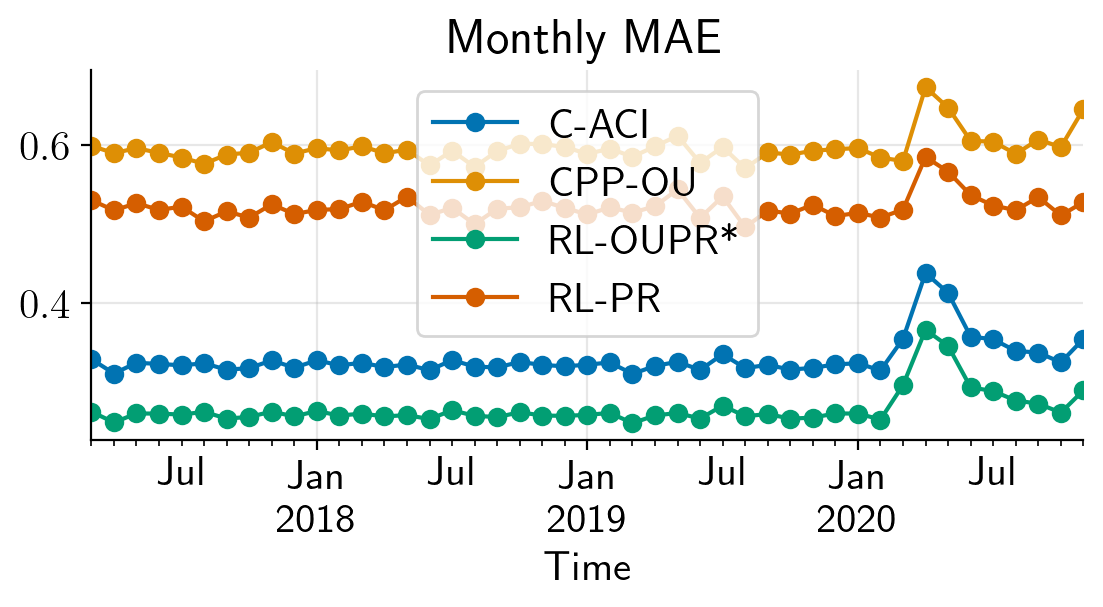

In [49]:
fig, ax = plt.subplots(figsize=(6.4, 4.8 * 0.5))

errs_df.drop("baseline", axis=1).abs().resample("ME").mean().plot(marker="o", ax=ax)
plt.title("Monthly MAE")

plt.grid(alpha=0.3)
plt.savefig(f"../figures/day-ahead-mae.png", dpi=300, bbox_inches="tight")

## Tracking

In [ ]:
del yrec

In [50]:
methods = [m for m in errs_df.columns if m != "baseline"]

yhat = errs_df + np.array(y)[:, None]
yhat = yhat * series_std[index].iloc[1:].values[:, None] + series_mean[index].iloc[1:].values[:, None]

y_true = np.array(y)[:, None] * series_std[index].iloc[1:].values[:, None] + series_mean[index].iloc[1:].values[:, None]
y_true = pd.Series(y_true.ravel(), index=yhat.index)

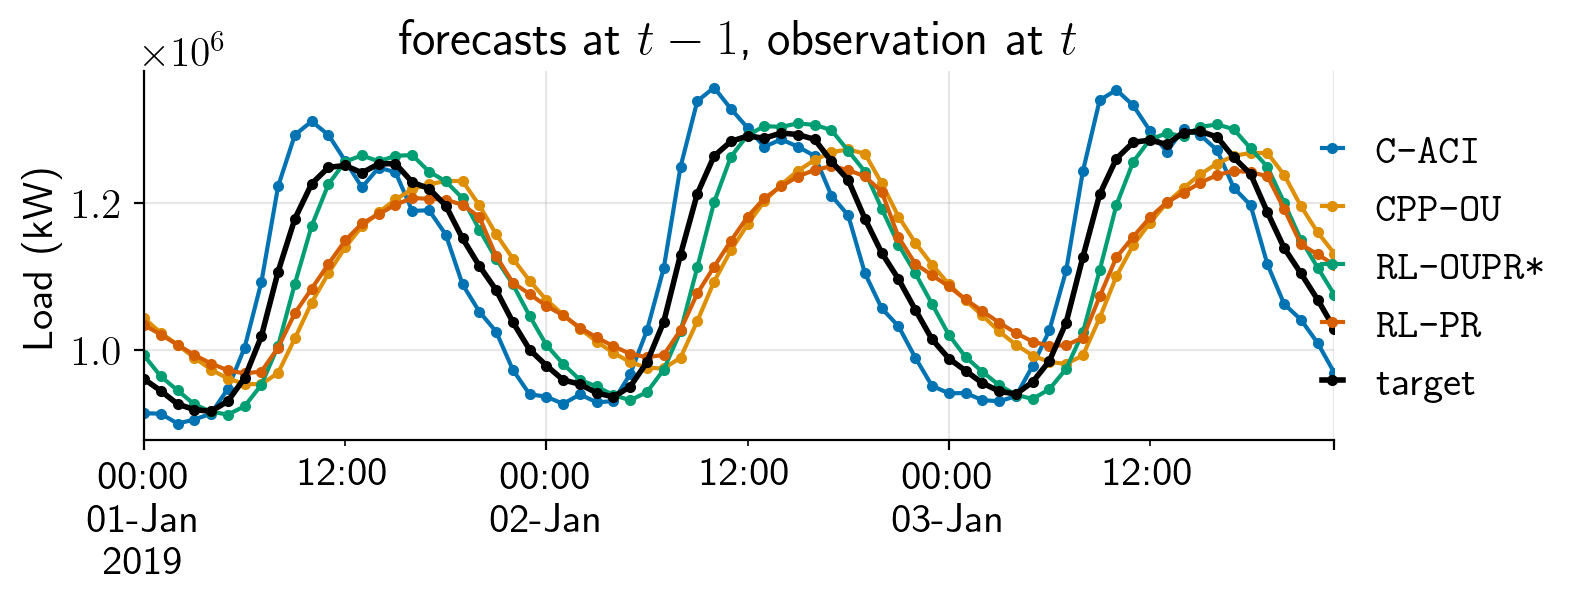

In [51]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.5))

time_slice = slice("2019-01-01", "2019-01-03")

for method in methods:
    label = r"\texttt{" + method + "}"
    yhat[method][time_slice].plot(marker="o", markersize=3, label=label)

y_true[time_slice].plot(label="target", c="black", marker="o", markersize=3, linewidth=2)
plt.title("forecasts at $t-1$, observation at $t$")
plt.ylabel(target)
plt.xlabel("")
plt.legend(loc="lower right", bbox_to_anchor=(1.21, 0), frameon=False, handlelength=0.5)
plt.grid(alpha=0.3)
plt.savefig(f"../figures/day-ahead-forecast.png", dpi=300, bbox_inches="tight")

## Plot over periods

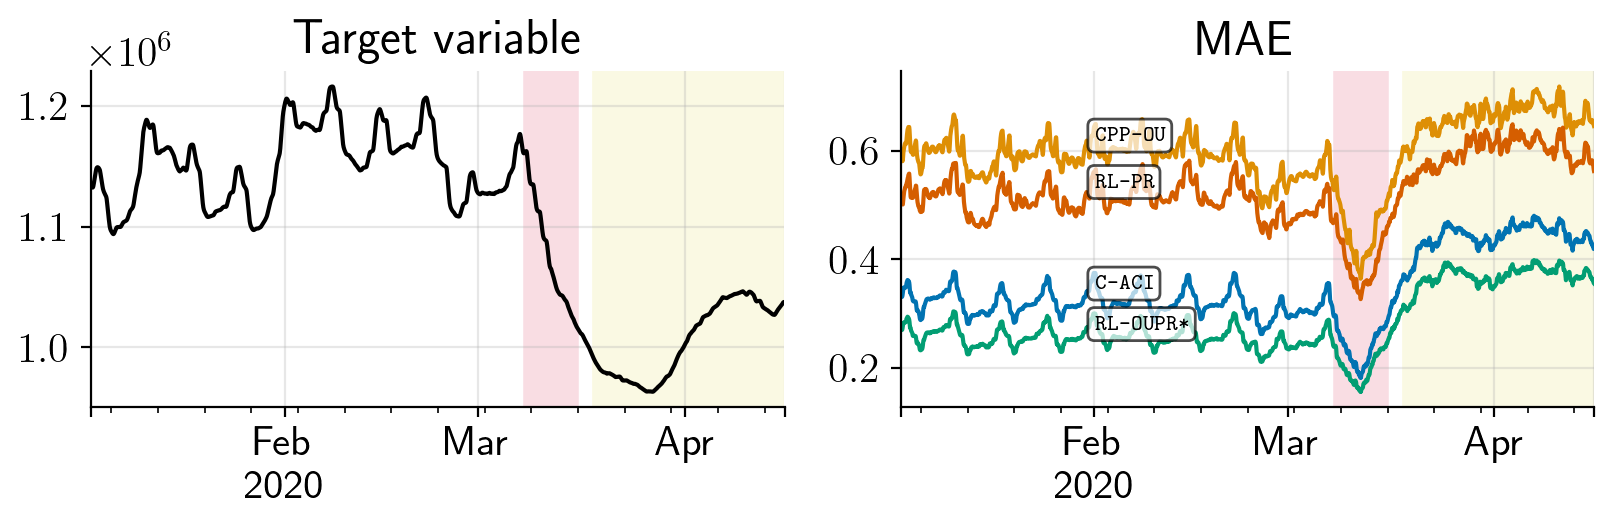

In [94]:
fig, axs = plt.subplots(1, 2, figsize=(6.4 * 1.3, 4.8 * 0.6))

daterange = slice("01-03-2020", "04-15-2020")
date_abrupt = datetime(2020, 3, 12)
date_gradual = datetime(2020, 4, 8)

plt.sca(axs[0])
# y_true.pct_change().abs().rolling(7 * 24).mean()[daterange].plot(c="black", ax=axs[0])
y_true.rolling(5 * 24).mean()[daterange].plot(c="black", ax=axs[0])
plt.title("Target variable")
plt.grid(alpha=0.3)
plt.xlabel("")

plt.axvline(x=date_abrupt, c="#F1ABB9", alpha=0.4, linewidth=20, zorder=0)
plt.axvline(x=date_gradual, c="#F4F1BB", alpha=0.4, linewidth=100, zorder=0)

plt.sca(axs[1])
err_range = errs_df.drop("baseline", axis=1).abs().rolling(5 * 24).mean()[daterange]
err_range.plot(ax=axs[1])
plt.grid(alpha=0.3)

plt.title("MAE")
plt.legend([], frameon=False)
plt.axvline(x=date_abrupt, c="#F1ABB9", alpha=0.4, linewidth=20, zorder=0)
plt.axvline(x=date_gradual, c="#F4F1BB", alpha=0.4, linewidth=100, zorder=0)
plt.xlabel("")
# plt.legend(loc="lower right", bbox_to_anchor=(1.21, 0), frameon=False, handlelength=0.5)

date_annot = datetime(2020, 2, 1, 1)
values_annot = err_range.loc[date_annot]

for label in values_annot.keys():
    # color = "teal" if "RL-SPR" == label else "crimson"
    color = "black"
    tlabel = r"$\texttt{" + label + "}$"
    plt.text(
        date_annot, values_annot[label], tlabel, size=8, verticalalignment="top", color=color,
        bbox=dict(facecolor='white', edgecolor="black", boxstyle="round", alpha=0.7)
    )
plt.tight_layout()
plt.savefig("../figures/day-ahead-abrupt-drift-comparison.png", dpi=300, bbox_inches="tight")

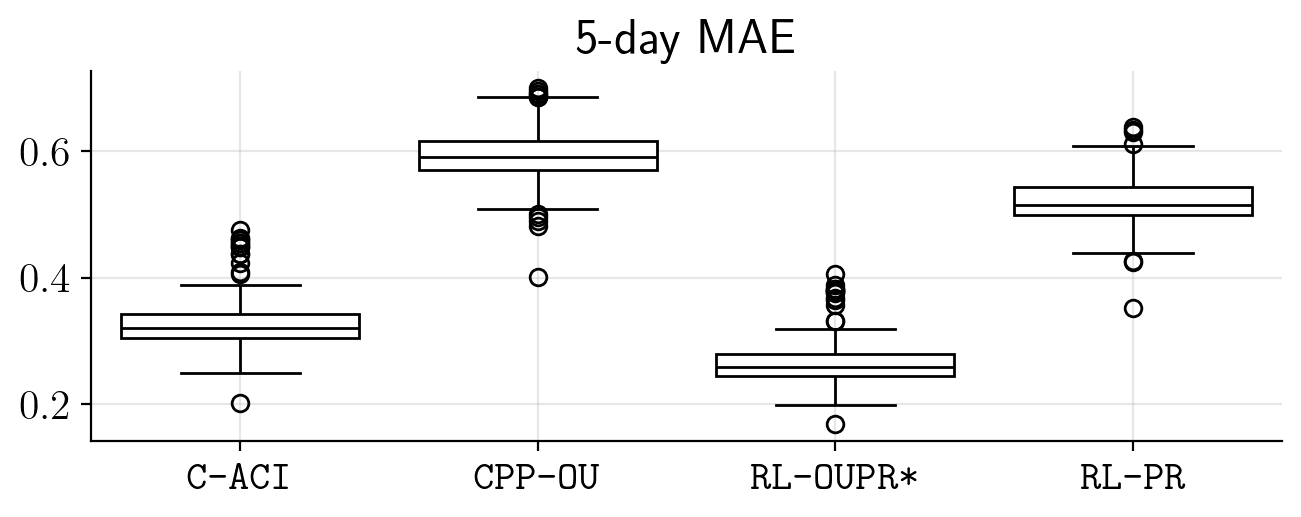

In [53]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.5))

plt.title("5-day MAE")
sns.boxplot(
    x="variable",
    y="value",
    data=errs_df.drop("baseline", axis=1).abs().resample("5D").mean().melt(),
    color="white",
    linecolor="black"
)

# ticks = plt.gca().get_xticklabels()
pos, ticks = plt.xticks()
newlabels = []
for tick in ticks:
    label = tick.get_text()
    label = r"$\texttt{" + label + "}$"
    newlabels.append(label)
plt.xticks(pos, newlabels)

plt.xlabel("")
plt.ylabel("")
plt.grid(alpha=0.3)
plt.savefig("../figures/day-ahead-results.png", dpi=300, bbox_inches="tight")